## Linear Models
Try again to use LinearRegression() and Lasso() models based off of input from Kaggle [forum](https://www.kaggle.com/c/allstate-claims-severity/forums/t/24749/linear-models-predicting-very-large-values).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.linear_model import Lasso, LinearRegression
from copy import deepcopy
import os
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

%matplotlib inline

In [2]:
loc = '/Users/elena/Documents/Kaggle/Allstate/data/'
train = pd.read_csv(os.path.join(loc,'train.csv'))
train.drop('id',axis=1,inplace=True)

test = pd.read_csv(os.path.join(loc,'test.csv'))
ids = test['id']
test.drop('id',axis=1,inplace=True)

submission = pd.read_csv(os.path.join(loc,"sample_submission.csv"))

In [3]:
# List of categorical columns
keepcats = [col for col in train.columns if 'cat' in col]
# List of continuous columns
keepcont = [col for col in train.columns if 'cont' in col]

print 'Categorical: ',len(keepcats)
print 'Continuous: ',len(keepcont)

Categorical:  116
Continuous:  14


In [4]:
# Remove some highly correlated continuous features:
newlist = deepcopy(keepcont)
newlist.remove("cont1")
newlist.remove("cont11")
newlist.remove("cont6")

# Take the logarithm of the 'loss' column. 
dataset_cont = train[newlist]
dataset_cont['log-loss']=np.log1p(train['loss'].values)
dataset_cont.head()

/Users/elena/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,cont2,cont3,cont4,cont5,cont7,cont8,cont9,cont10,cont12,cont13,cont14,log-loss
0,0.245921,0.187583,0.789639,0.310061,0.335060,0.30260,0.67135,0.83510,0.594646,0.822493,0.714843,7.702637
1,0.737068,0.592681,0.614134,0.885834,0.436585,0.60087,0.35127,0.43919,0.366307,0.611431,0.304496,7.158203
2,0.358319,0.484196,0.236924,0.397069,0.315545,0.27320,0.26076,0.32446,0.373424,0.195709,0.774425,8.008396
3,0.555782,0.527991,0.373816,0.422268,0.391128,0.31796,0.32128,0.44467,0.321570,0.605077,0.602642,6.846784
4,0.159990,0.527991,0.473202,0.704268,0.247408,0.24564,0.22089,0.21230,0.202213,0.246011,0.432606,7.924742


In [5]:
def convert_strings(pdseries):
    # Function inputs a column of a pandas DataFrame,
    # determines the number of unique entries, and assigns 
    # an integer to each entry. 
    # This is to avoid issues with non-integer data.
      
    array = np.array(pdseries)
    vals = np.unique(array)
    nums = np.arange(0,len(vals),1)
    #new_array = np.zeros(len(array),dtype='int')     
    new_array = np.zeros(len(array),dtype='float')
    
    #nums = np.linspace(0,1,len(vals))
    #new_array = np.zeros(len(array))

    for j in range(len(vals)):
        ind = np.where(array==vals[j])[0]
        new_array[ind]=nums[j]
     
    # Returns a numpy array with an integer for each entry
    return new_array

/Users/elena/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/elena/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


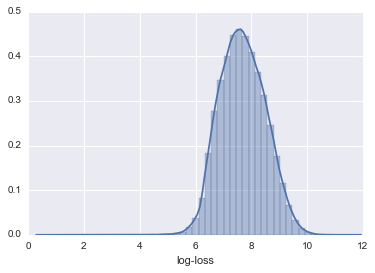

In [6]:
# Based on analysis done in Kaggle forum, get rid of a couple highly
# correlated categorical variables:
#get_rid_of = list(['cat2-','cat6-','cat8-','cat7-','cat16-'])
new_cat_list = deepcopy(keepcats)
new_cat_list.remove("cat2")
new_cat_list.remove("cat6")
new_cat_list.remove("cat8")
new_cat_list.remove("cat7")
new_cat_list.remove("cat16")

dataset_cat = train[new_cat_list]
for cat in new_cat_list:
    dataset_cat.loc[:,cat]=convert_strings(dataset_cat.loc[:,cat])
    

final_data = pd.concat([dataset_cont,dataset_cat],axis=1)
y = final_data['log-loss']
x = final_data.drop('log-loss',axis=1)

sns.distplot(y)

In [7]:
final_data.head()

,cont2,cont3,cont4,cont5,cont7,cont8,cont9,cont10,cont12,cont13,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,0.245921,0.187583,0.789639,0.310061,0.335060,0.30260,0.67135,0.83510,0.594646,0.822493,...,9.0,6.0,45.0,28.0,2.0,19.0,55.0,0.0,14.0,269.0
1,0.737068,0.592681,0.614134,0.885834,0.436585,0.60087,0.35127,0.43919,0.366307,0.611431,...,10.0,10.0,33.0,65.0,0.0,22.0,38.0,0.0,14.0,85.0
2,0.358319,0.484196,0.236924,0.397069,0.315545,0.27320,0.26076,0.32446,0.373424,0.195709,...,5.0,0.0,2.0,85.0,0.0,28.0,5.0,0.0,8.0,153.0
3,0.555782,0.527991,0.373816,0.422268,0.391128,0.31796,0.32128,0.44467,0.321570,0.605077,...,10.0,10.0,33.0,67.0,2.0,39.0,4.0,0.0,14.0,79.0
4,0.159990,0.527991,0.473202,0.704268,0.247408,0.24564,0.22089,0.21230,0.202213,0.246011,...,6.0,1.0,66.0,50.0,2.0,50.0,38.0,0.0,10.0,55.0


In [8]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.8)

newmodel = LinearRegression()
newmodel.fit(X_train,y_train)
pred = newmodel.predict(X_test)
print mean_absolute_error(np.expm1(y_test),np.expm1(pred))

newnew = LinearRegression(normalize=True)
newnew.fit(X_train,y_train)
pred2 = newnew.predict(X_test)
print mean_absolute_error(np.expm1(y_test),np.expm1(pred2))


1296.06510249
1296.06510249


In [9]:
full_list = newlist+new_cat_list
test_dataset = test[full_list]

for cat in new_cat_list:
    test_dataset.loc[:,cat]=convert_strings(test_dataset.loc[:,cat])
test_dataset.head()

,cont2,cont3,cont4,cont5,cont7,cont8,cont9,cont10,cont12,cont13,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,0.299102,0.246911,0.402922,0.281143,0.317681,0.61229,0.34365,0.38016,0.369858,0.704052,...,11.0,10.0,30.0,26.0,0.0,35.0,23.0,0.0,16.0,169.0
1,0.620805,0.654310,0.946616,0.836443,0.443760,0.71330,0.51890,0.60401,0.675759,0.453468,...,5.0,1.0,30.0,58.0,3.0,32.0,58.0,0.0,11.0,173.0
2,0.737068,0.711159,0.412789,0.718531,0.325779,0.29758,0.34365,0.30529,0.241676,0.258586,...,6.0,0.0,30.0,62.0,2.0,46.0,4.0,0.0,10.0,51.0
3,0.681761,0.592681,0.354893,0.397069,0.342355,0.40028,0.33237,0.31480,0.341872,0.592264,...,10.0,10.0,30.0,61.0,0.0,25.0,9.0,0.0,15.0,76.0
4,0.299102,0.263570,0.696873,0.302678,0.391833,0.23688,0.43731,0.50556,0.352251,0.301535,...,4.0,1.0,2.0,100.0,0.0,30.0,45.0,2.0,9.0,163.0


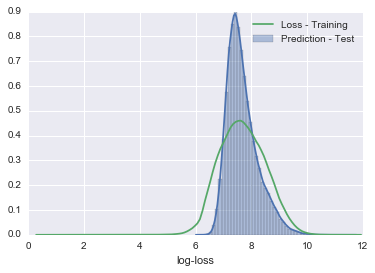

In [10]:
# Use full dataset to make a model
model = LinearRegression()
model.fit(x,y)

submission.iloc[:, 1] = np.expm1(model.predict(test_dataset))
#submission.to_csv(loc+'linear_reg1.csv', index=None)

fig,ax = plt.subplots()
sns.distplot(model.predict(test_dataset),ax=ax,label='Prediction - Test')
sns.distplot(y,hist=False,ax=ax,label='Loss - Training')
plt.legend()

## Lasso

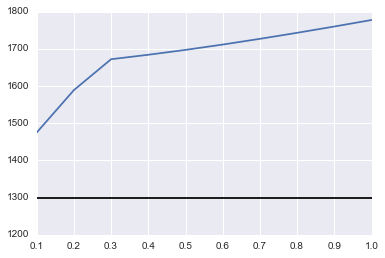

In [11]:
alphas = np.linspace(0.1,1.0,10)

maes = []
for a in alphas:
    model = Lasso(alpha=a)
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    maes.append(mean_absolute_error(np.expm1(y_test),np.expm1(pred)))
    
plt.plot(alphas,maes)
plt.hlines(1298,0.1,1.0)